In [609]:
import os
import sys
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import pymongo
import scipy.stats as stats
from PIL import Image
import io
import json
import requests
from collections import Counter
import mediapy as media 
import tqdm.notebook as tqdm
import seaborn as sns

In [526]:
CONN = pymongo.MongoClient("mongodb://localhost:27017/")
DB = CONN["mlve_results"]["results"]
df = pd.DataFrame(list(DB.find()))
S3_root = "https://mlve-v1.s3.us-east-2.amazonaws.com/"

In [527]:
def points_in_circle(radius, x0=0, y0=0, n_points=100, uniform=False, max_loc=511, min_loc=0):
    """
    returns points in a circle with a given radius, centered at x0, y0
    """
    theta = np.linspace(0, 2*np.pi, n_points)
    a, b = 1 * np.cos(theta), 1 * np.sin(theta)
    r = np.random.rand((n_points))
    if uniform:
        # Balances the density of points in the circle
        r = np.sqrt(r)

    x, y = r * np.cos(theta), r * np.sin(theta)
    xpoints, ypoints = x * radius + x0, y * radius + y0
    xpoints = np.clip(xpoints, min_loc, max_loc)
    ypoints = np.clip(ypoints, min_loc, max_loc)
    return xpoints, ypoints

In [528]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103565 entries, 0 to 103564
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   _id              103565 non-null  object 
 1   ID               103565 non-null  object 
 2   imageURL         103565 non-null  object 
 3   gt               73337 non-null   object 
 4   response         103565 non-null  object 
 5   score            75852 non-null   object 
 6   probeLocation    103565 non-null  object 
 7   batchID          103565 non-null  float64
 8   expName          103565 non-null  object 
 9   iterationName    103565 non-null  object 
 10  experiment_type  103565 non-null  object 
dtypes: float64(1), object(10)
memory usage: 8.7+ MB


In [718]:
def image_from_url(url, convert=False):
    try:
        response = requests.get(url)
    except Exception as e:
        print("Error: ", e)
        return None
    
    if response.status_code != 200:
        print("Error: ", response.status_code)
        return None
        
    img = Image.open(io.BytesIO(response.content))
    if convert:
        img = img.convert("L")
    return np.array(img)

def load_model_prediction(task, dataset, image_id, results_dir = "/Users/yonifriedman/Projects/mlve/results/model_predictions/"):
    """
        Loads model prediction for a given image/task/dataset combination
    """
    images_path = os.path.join(results_dir, task, dataset, "*.png")
    images = glob(images_path)
    images.sort()
    image_path = images[image_id]
    img = Image.open(image_path)
    return np.array(img)

def trunc(values, decs=3):
    return np.trunc(values*10**decs)/(10**decs)

def get_ground_truth(task, dataset, image_id):
    if task == "depth":
        gt_url = f"https://mlve-v1.s3.us-east-2.amazonaws.com/{dataset}/depths/depth_{image_id:03d}.png"
    elif task == "segmentation":
        gt_url = f"https://mlve-v1.s3.us-east-2.amazonaws.com/{dataset}/masks/mask_{image_id:03d}.png"
    elif task == "surface-normals":
        gt_url = f"https://mlve-v1.s3.us-east-2.amazonaws.com/{dataset}/normals/normal_{image_id:03d}.png"
    
    gt = image_from_url(gt_url)
    return gt


def get_model_responses(task, dataset, image_id, probe_location, n_samples=10, gt=None, sample_strategy="uniform"):
    """
        Sample responses for a given trial from a model. A trial is defined as a probe location, for which there
        are n_samples human responses. The strategy for sampling model responses comes with assumptions about
        what humans are doing. Uniform sampling means that humans deal with uncertainty over probe location
        by picking a random location in the circle. Another option is to use the average value of the probe location.

        Parameters:
        ----------  
        task: str: "depth", "segmentation" or "surface-normals"
        dataset: str: "nsd", "tdw", "hypersim_v3", "gestalt_shapegen" 
        image_id: int: image id 
        probe_location: tuple: (left, right) probe location (or just (x, y) for surface-normals)
        n_samples: int: number of samples to take from the model
        gt: np.array: ground truth (if available)
        sample_strategy: str: "uniform" or "average"

        Returns:
        ----------
        responses: list: list of model responses
        predicted_features: np.array: predicted features from the model (either depth map, segmentation masks, or surface normals)
        score: float: model accuracy (if available)
    """
    predicted_features = load_model_prediction(task, dataset, image_id)

    responses = []
    accuracies = []
    if task == "depth" or task == "segmentation":
        left, right = probe_location
        left_xs, left_ys = points_in_circle(radius=7, x0=left[0], y0=left[1], n_points=n_samples)
        right_xs, right_ys = points_in_circle(radius=7, x0=right[0], y0=right[1], n_points=n_samples)
        for i in range(n_samples):
            lx = int(left_xs[i])
            ly = int(left_ys[i])
            rx = int(right_xs[i])
            ry = int(right_ys[i])

            if dataset == "nsd" and task == "depth":
                # Resize depth map to 512 x 512
                predicted_features = np.array(Image.fromarray(predicted_features).resize((512, 512), resample=Image.Resampling.BILINEAR))
                
            left_feature = predicted_features[ly, lx]
            right_feature = predicted_features[ry, rx]
            if task == "depth":
                if predicted_features.max() > 1:
                   # Normalize depth map to 0, 1
                    predicted_features = (predicted_features - np.min(predicted_features)) / (np.max(predicted_features) - np.min(predicted_features))
                    predicted_features = trunc(predicted_features, decs=2) # truncate decimals
                
                # Task is to say which point is closer to camera 
                # 0 corresponds to left being closer, 1 corresponds to right being closer, 2 corresponds to equal distance
                # The current MiDaS depth maps are backwards, so 1 is closer and 0 is further
                if (left_feature > right_feature):
                    responses.append(0)
                elif (right_feature > left_feature):
                    responses.append(1)
                else:
                    responses.append(0.5)

                if gt is not None:
                    gt_left = trunc(gt[left[1], left[0]], 3)
                    gt_right = trunc(gt[right[1], right[0]], 3)
                    if (gt_left < gt_right):
                        gt_response = 0
                    elif (gt_right < gt_left):
                        gt_response = 1
                    else:
                        gt_response = 0.5

                    accuracies.append(gt_response == responses[-1])

            elif task == "segmentation":
                if (np.array_equal(left_feature, right_feature)):
                    responses.append(1)
                else:
                    responses.append(0)

                if gt is not None:
                    gt_left = gt[left[1], left[0]]
                    gt_right = gt[right[1], right[0]]
                    if (np.array_equal(gt_left, gt_right)):
                        gt_response = 1
                    else:
                        gt_response = 0

                    accuracies.append(gt_response == responses[-1])

    elif task == "surface-normals":
        xs, ys = points_in_circle(radius=4, x0=probe_location[0], y0=probe_location[1], n_points=n_samples)
        for i in range(n_samples):
            x = xs[i]
            y = ys[i]
            feature = predicted_features[y, x]
            responses.append(feature)

    if len(accuracies) > 0:
        score = np.mean(accuracies)
    else:
        score = None
    return responses, predicted_features, score

def get_human_responses(task, dataset, image_id):
    """ 
        Loads human responses for a given image/task/dataset combination
        from dataframe of behavioral results
    """
    S3_root = "https://mlve-v1.s3.us-east-2.amazonaws.com/"
    trials = df[(df["experiment_type"] == task) & (df["imageURL"] == os.path.join(S3_root, dataset, "images", f"image_{image_id:03d}.png"))]

    responses = {}
    for i, row in trials.iterrows():
        batchID = int(row["batchID"])
        if batchID not in responses:
            responses[batchID] = {"probeLocation": row["probeLocation"], "responses": [], "url": row["imageURL"], "score": []}
        
        resp = row["response"]
        if task == "depth":
            if resp == 2:
                resp = 0.5

        elif task == "segmentation":
            resp = int(resp)
            
        if row["score"] is not None:    
            responses[batchID]["score"].append(row["score"])

        responses[batchID]["responses"].append(resp)

    return responses

In [719]:
def count_resps(resps, task="depth"):
    if task == "depth":
        counts = [0, 0, 0]
    else: 
        counts = [0, 0]
        
    for resp in resps:
        if resp == 0:
            counts[0] += 1
        elif resp == 1:
            counts[1] += 1
        else:
            counts[2] += 1
    return counts

In [720]:
import scipy

data = {}
task = "segmentation"
model_comparison = "distribution" # or average

for dataset in ["tdw", "hypersim_v3", "tdw", "gestalt_shapegen"]:
    stats = {}
    stats["model_accuracy"] = []
    stats["human_accuracy"] = []
    stats["model_responses"] = []
    stats["human_responses"] = []
    stats["model_response_counts"] = []
    stats["human_response_counts"] = []

    for image_id in tqdm.tqdm(range(100)):
        human_responses = get_human_responses(task, dataset, image_id)
        gt = get_ground_truth(task, dataset, image_id)
        for batch_id in human_responses:
            n_samples = len(human_responses[batch_id]["responses"])
            model_responses, features, score = get_model_responses(task, dataset, image_id, human_responses[batch_id]["probeLocation"], n_samples=n_samples, gt=gt)
            if score:
                stats["model_accuracy"].append(score)
                stats["human_accuracy"].append(np.mean(human_responses[batch_id]["score"]))

            human_resps = np.array(human_responses[batch_id]["responses"])
            model_resps = np.array(model_responses)

            if task == "depth" or task == "segmentation":
                human_resp_counts = count_resps(human_resps, task=task)
                model_resp_counts = count_resps(model_resps, task=task)
            else:
                human_resp_counts = scipy.stats.mode(human_resps)[0][0]
                model_resp_counts = scipy.stats.mode(model_resps)[0][0]
           
            stats["model_responses"].append(model_resps)
            stats["human_responses"].append(human_resps)
            stats["model_response_counts"].append(model_resp_counts)
            stats["human_response_counts"].append(human_resp_counts)

    data[dataset] = stats

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]






tdw


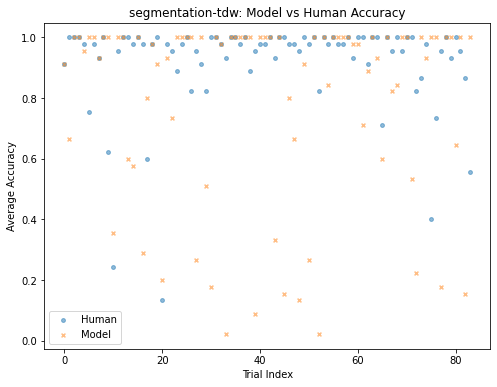

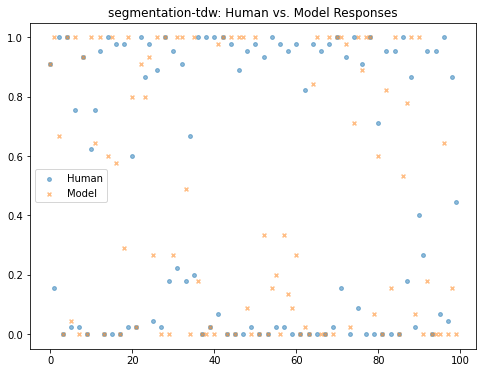

/Users/yonifriedman/.miniconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/yonifriedman/.miniconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


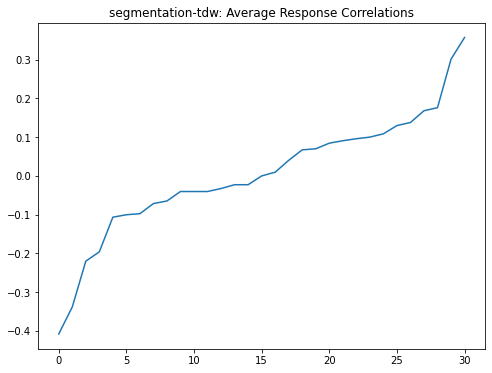

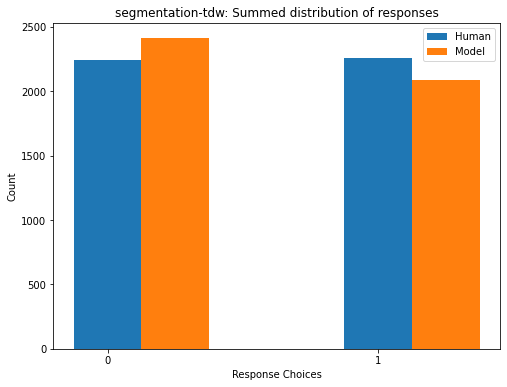

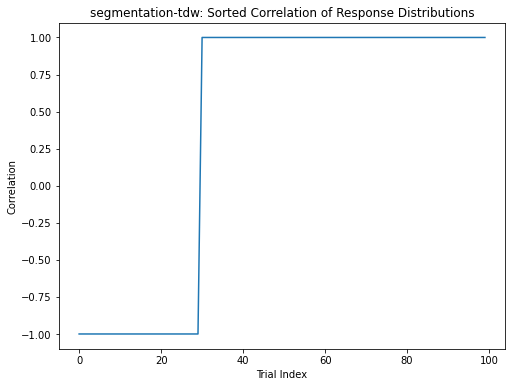

Average-Response Correlation: 0.39775617606519253
Average-Response Cosine Distance: 0.2737251857398255
Response Distribution Correlation: 0.4
Response Distribution Cosine Distance: 0.26017281517273577
Accuracy Correlation: 0.20057439653866171
Model Accuracy: 0.7910052910052909
Human Accuracy: 0.9185185185185185





hypersim_v3


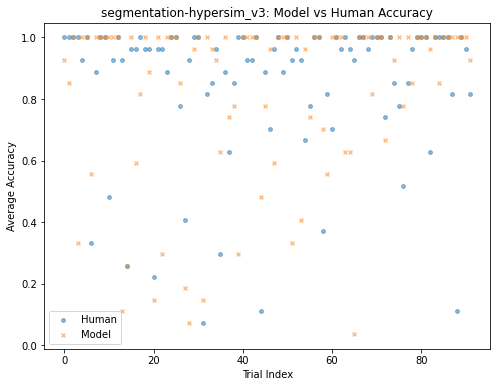

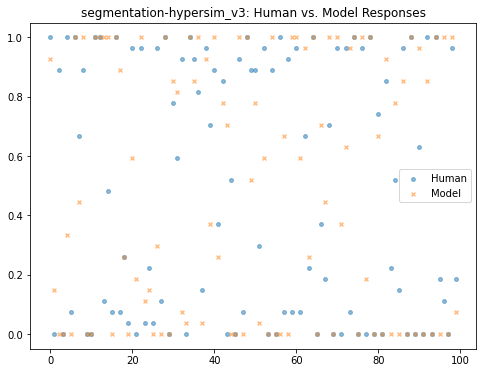

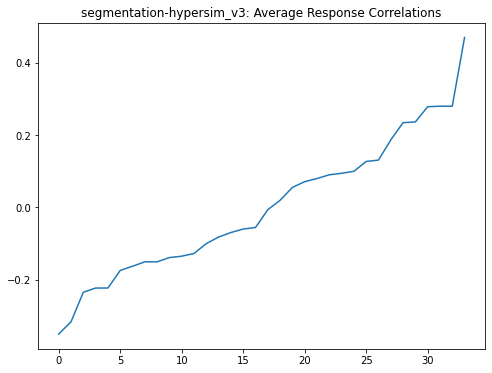

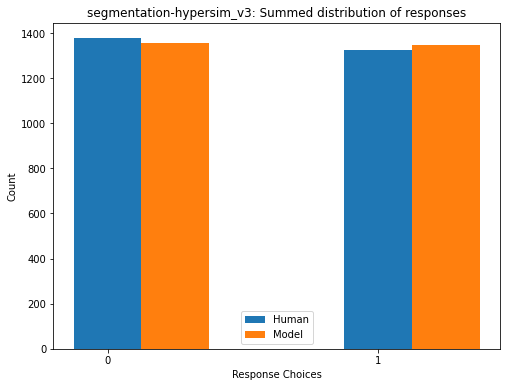

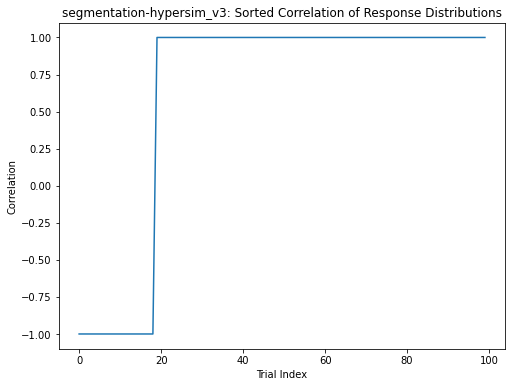

Average-Response Correlation: 0.6776198582505532
Average-Response Cosine Distance: 0.1374478307336151
Response Distribution Correlation: 0.6199999999999999
Response Distribution Cosine Distance: 0.1342947964699954
Accuracy Correlation: 0.3986172999831955
Model Accuracy: 0.8252818035426731
Human Accuracy: 0.8534621578099838





gestalt_shapegen


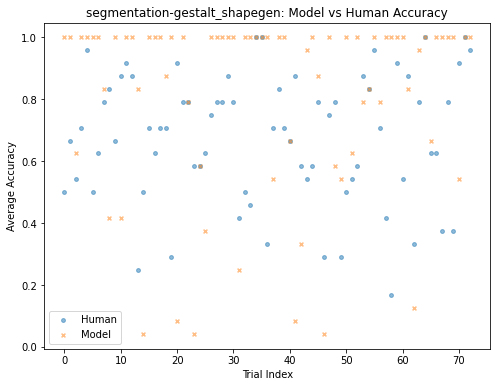

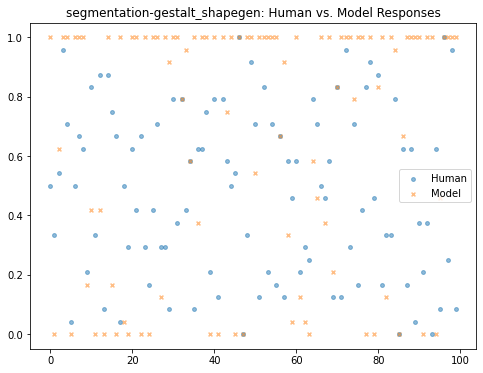

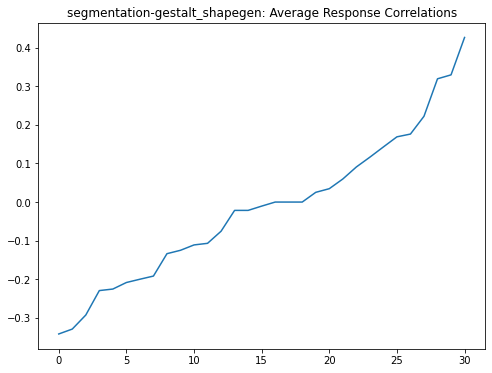

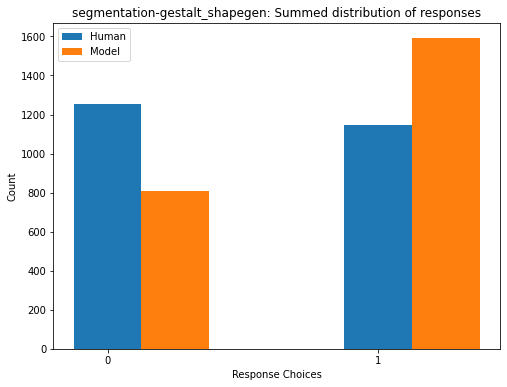

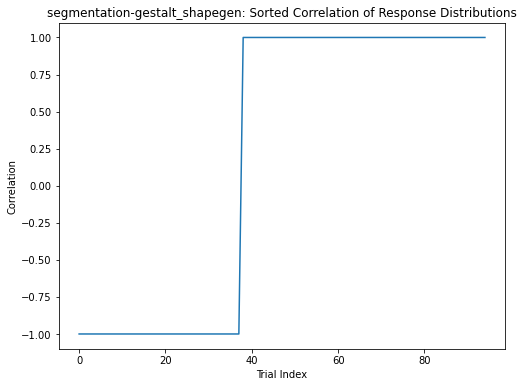

Average-Response Correlation: 0.22367798251789617
Average-Response Cosine Distance: 0.21043323294954241
Response Distribution Correlation: 0.2
Response Distribution Cosine Distance: 0.2726318306158483
Accuracy Correlation: 0.1513098681214101
Model Accuracy: 0.807648401826484
Human Accuracy: 0.6763698630136986


In [722]:
def compute_stats(stats, dataset, task):
    if "model_accuracy" in stats:
        model_accuracy = np.array(stats["model_accuracy"])
        human_accuracy = np.array(stats["human_accuracy"])
        acc_corrs = np.corrcoef(human_accuracy, model_accuracy)[0, 1]
        fig = plt.figure(figsize=(8, 6))
        plt.scatter(range(len(human_accuracy)), human_accuracy, s=15, alpha=0.5, label="Human")
        plt.scatter(range(len(model_accuracy)), model_accuracy, s=15, alpha=0.5, marker="x", label="Model")
        plt.legend()
        plt.title(f"{task}-{dataset}: Model vs Human Accuracy")
        plt.ylabel("Average Accuracy")
        plt.xlabel("Trial Index")
        plt.show()
    else: 
        acc_corrs = None

    human_responses = [np.mean(x) for x in stats["human_responses"]]
    model_responses = [np.mean(x) for x in stats["model_responses"]]
    
    plt.figure(figsize=(8, 6))
    plt.scatter(range(len(human_responses)), human_responses, s=15, alpha=0.5, label="Human")
    plt.scatter(range(len(model_responses)), model_responses, s=15, alpha=0.5, marker="x", label="Model")
    plt.legend()
    plt.title(f"{task}-{dataset}: Human vs. Model Responses")
    plt.show()

    avg_corrs = np.corrcoef(human_responses, model_responses)[0, 1]
    avg_cos_dist = scipy.spatial.distance.cosine(human_responses, model_responses)
    trial_level_avg_resp_corrs = np.sort([np.corrcoef(x, y)[0, 1] for x, y in zip(stats["human_responses"], stats["model_responses"])])
    plt.figure(figsize=(8, 6))
    plt.plot(range(len(human_responses)), trial_level_avg_resp_corrs)
    plt.title(f"{task}-{dataset}: Average Response Correlations")
    plt.show()

    human_resp_counts = np.array(stats["human_response_counts"])
    model_resp_counts = np.array(stats["model_response_counts"])
    
    fig = plt.figure(figsize=(8,6))
    summed_human_resp_counts = human_resp_counts.sum(axis=0)
    summed_model_resp_counts = model_resp_counts.sum(axis=0)
    plt.bar(np.arange(len(summed_human_resp_counts)), summed_human_resp_counts, width=0.25, label="Human")
    plt.bar(np.arange(len(summed_model_resp_counts)) + 0.25, summed_model_resp_counts, width=0.25, label="Model")
    plt.xlabel("Response Choices")
    plt.xticks(np.arange(len(summed_human_resp_counts))) 
    plt.ylabel("Count")
    plt.title(f"{task}-{dataset}: Summed distribution of responses")
    plt.legend()
    plt.show()

    distributional_corr = [np.corrcoef(x, y)[0, 1] for x, y in zip(human_resp_counts, model_resp_counts)]
    distributional_cos_dist = np.mean([scipy.spatial.distance.cosine(x, y) for x, y in zip(human_resp_counts, model_resp_counts)])
    
    distributional_corr = np.sort(distributional_corr)

    fig = plt.figure(figsize=(8, 6))
    plt.plot(distributional_corr)
    plt.title(f"{task}-{dataset}: Sorted Correlation of Response Distributions")
    plt.xlabel("Trial Index")
    plt.ylabel("Correlation")
    plt.show()

    return {"Average-Response Correlation": avg_corrs, 
            "Average-Response Cosine Distance": avg_cos_dist, 
            "Response Distribution Correlation": np.nanmean(distributional_corr), 
            "Response Distribution Cosine Distance": distributional_cos_dist,
            "Accuracy Correlation": acc_corrs,
            "Model Accuracy": model_accuracy.mean(),
            "Human Accuracy": human_accuracy.mean()}

stats = None
for dataset in data:
    print("\n"*4)
    print(dataset)
    stats = compute_stats(data[dataset], dataset, task)
    for stat in stats:
        print(f"{stat}: {stats[stat]}")

# Save the stats
with open(f"{task}_stats.json", "w") as f:
    json.dump(stats, f)
